# US Election 2020

In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from scipy.stats import zscore

In [2]:
# Step 1: Unzip and load the dataset
zip_file_path = 'US Election 2020.zip'
extracted_folder = 'US_Election_Data/'

# Unzipping the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Load the CSV file into a DataFrame
csv_file_path = extracted_folder + 'US_Election_dataset_v1.csv'
election_data = pd.read_csv(csv_file_path)

In [3]:
# Step 2: Inspect the data
print("Initial Dataset Info:")
print(election_data.info())
print("\nInitial Dataset Description:")
print(election_data.describe())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 35 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Unnamed: 0                                                                 3143 non-null   object 
 1   county                                                                     3143 non-null   object 
 2   state                                                                      3143 non-null   object 
 3   2020 Democrat vote raw                                                     3143 non-null   int64  
 4   2020 Democrat vote %                                                       3143 non-null   float64
 5   2020 Republican vote raw                                                   3143 non-null   int64  
 6   2020 Republican vote %            

In [4]:
# Step 3: Clean column names
election_data.columns = election_data.columns.str.strip()

In [5]:
# Step 4: Check for missing values
print("\nMissing values per column:")
print(election_data.isnull().sum())


Missing values per column:
Unnamed: 0                                                                   0
county                                                                       0
state                                                                        0
2020 Democrat vote raw                                                       0
2020 Democrat vote %                                                         0
2020 Republican vote raw                                                     0
2020 Republican vote %                                                       0
2020 other vote raw                                                          0
2020 other vote %                                                            0
Population with less than 9th grade education                                0
Population with 9th to 12th grade education, no diploma                      0
High School graduate and equivalent                                          0
Some College,No Degree  

In [6]:
# Step 5: Handle outliers using Z-scores
# Define a function to cap outliers using Z-scores
def cap_outliers(df, cols, threshold=3):
    for col in cols:
        z_scores = zscore(df[col])
        df[col] = np.where(z_scores > threshold, df[col].quantile(0.95), df[col])
        df[col] = np.where(z_scores < -threshold, df[col].quantile(0.05), df[col])
    return df

# Apply outlier capping to numeric columns
numeric_cols = election_data.select_dtypes(include=[np.number]).columns.tolist()
election_data = cap_outliers(election_data, numeric_cols)

In [7]:
# Step 6: Feature Engineering
election_data['total_votes'] = (
    election_data['2020 Democrat vote raw'] +
    election_data['2020 Republican vote raw'] +
    election_data['2020 other vote raw']
)

election_data['vote_share_democrat'] = (
    election_data['2020 Democrat vote raw'] / election_data['total_votes']
) * 100

election_data['vote_share_republican'] = (
    election_data['2020 Republican vote raw'] / election_data['total_votes']
) * 100

election_data['vote_share_diff'] = (
    election_data['vote_share_democrat'] - election_data['vote_share_republican']
)

In [9]:
# Step 7: Data Transformation
# Handle non-numeric entries in the skewed columns
skewed_cols = ['Median income (dollars)', 'Total Population']

for col in skewed_cols:
    # Remove non-numeric characters (e.g., commas, dollar signs)
    election_data[col] = election_data[col].replace({',': '', '\$': ''}, regex=True)
    
    # Convert the column to numeric, coercing errors to NaN
    election_data[col] = pd.to_numeric(election_data[col], errors='coerce')
    
    # Fill missing values with the median of the column
    election_data[col].fillna(election_data[col].median(), inplace=True)

# Apply log1p transformation
for col in skewed_cols:
    election_data[col] = np.log1p(election_data[col])

# Verify transformation
print("\nTransformed Columns:")
print(election_data[skewed_cols].head())


Transformed Columns:
   Median income (dollars)  Total Population
0                11.131899         10.981999
1                11.170998         12.353492
2                10.589434         10.135551
3                10.833089         10.012073
4                10.958514         10.987578


<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
C:\Users\milto\AppData\Local\Temp\ipykernel_19152\3321886599.py:7: SyntaxWarning: invalid escape sequence '\$'
  election_data[col] = election_data[col].replace({',': '', '\$': ''}, regex=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_19152\3321886599.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  election_data[col].fillna(election_data[col].median(), inplace=True)


In [12]:
# Step 8: Normalize numerical columns
scaler = StandardScaler()

# Select only numeric columns for PCA
numeric_cols = election_data.select_dtypes(include=[np.number]).columns.tolist()
election_data[numeric_cols] = scaler.fit_transform(election_data[numeric_cols])

In [13]:
# Step 9: Feature Selection for PCA
# Drop non-numeric or irrelevant columns
X = election_data[numeric_cols].drop(columns=['vote_share_democrat'], errors='ignore')
y = election_data['vote_share_democrat']

# Step 10: PCA Transformation
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X)

print(f"\nPCA reduced to {X_pca.shape[1]} components.")


PCA reduced to 16 components.


In [14]:
# Step 10: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


Linear Regression Evaluation:
Mean Absolute Error (MAE): 0.0386
Mean Squared Error (MSE): 0.0052
R-squared (R2): 0.9947


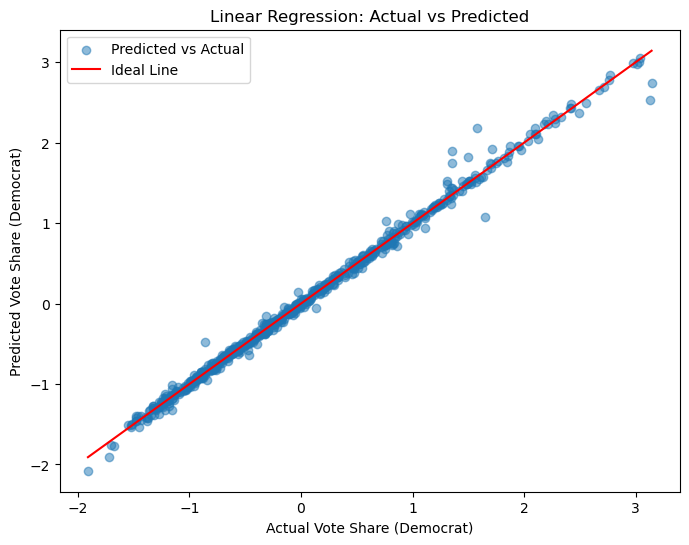


Ridge Regression Evaluation:
Mean Absolute Error (MAE): 0.0386
Mean Squared Error (MSE): 0.0052
R-squared (R2): 0.9947


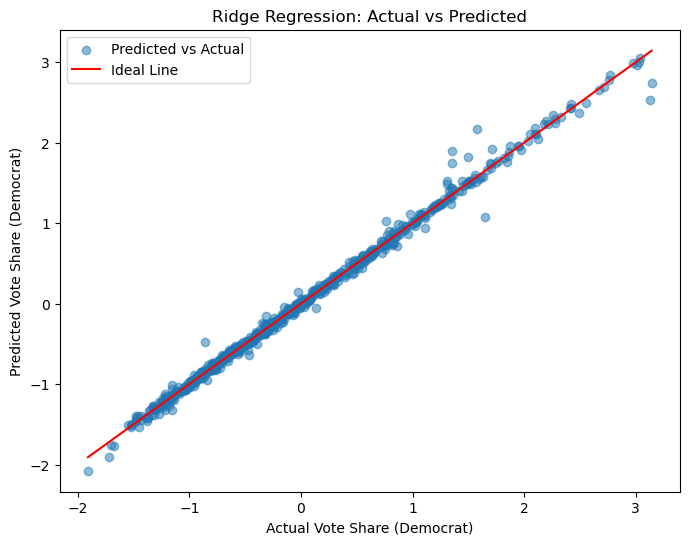


Lasso Regression Evaluation:
Mean Absolute Error (MAE): 0.1903
Mean Squared Error (MSE): 0.0602
R-squared (R2): 0.9392


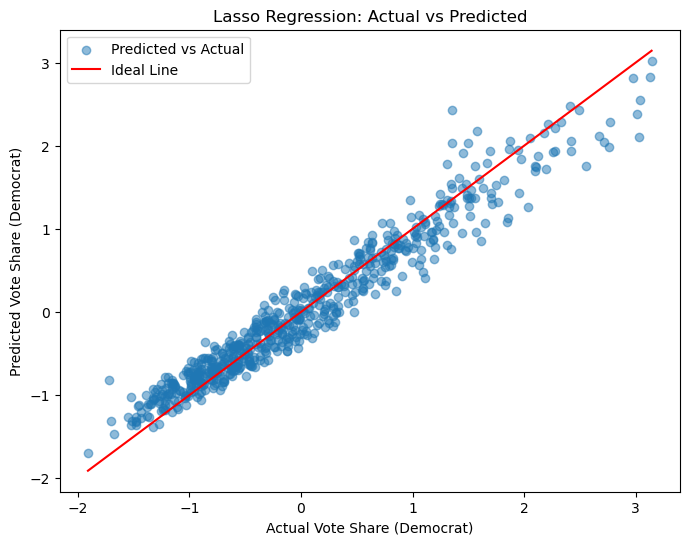


Random Forest Regressor Evaluation:
Mean Absolute Error (MAE): 0.1545
Mean Squared Error (MSE): 0.0454
R-squared (R2): 0.9541


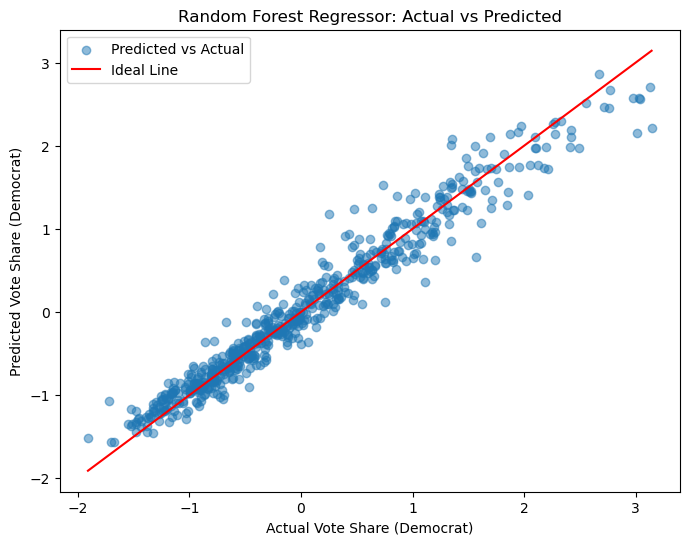

In [15]:
# Step 11: Train and Evaluate Models
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42)
}

for model_name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name} Evaluation:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Actual")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label="Ideal Line")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.xlabel("Actual Vote Share (Democrat)")
    plt.ylabel("Predicted Vote Share (Democrat)")
    plt.legend()
    plt.show()

In [16]:
# Step 12: Cross-Validation for Random Forest
rf_model = models["Random Forest Regressor"]
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"\nRandom Forest Cross-Validation R2 Scores: {cv_scores}")
print(f"Average R2 Score: {np.mean(cv_scores):.4f}")


Random Forest Cross-Validation R2 Scores: [0.94438805 0.94347531 0.94465766 0.94294642 0.94146193]
Average R2 Score: 0.9434


In [ ]:
# Exploratory Data Analysis

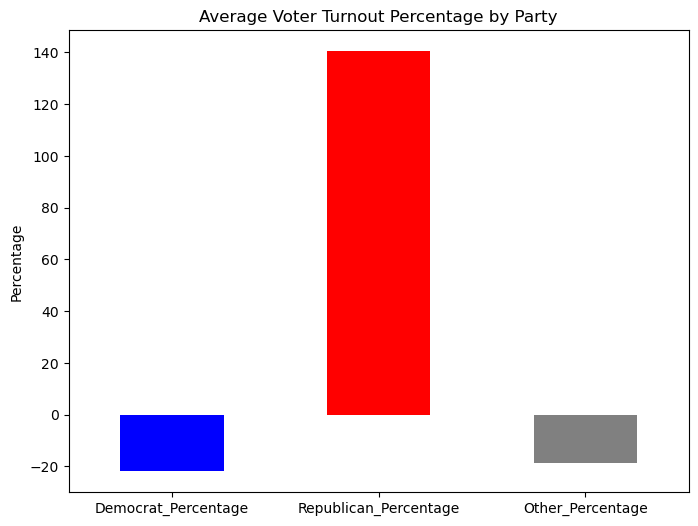

In [18]:
# Voter Turnout by Party

# Calculate total votes and vote percentage
election_data['Total_Votes'] = (election_data['2020 Democrat vote raw'] + 
                                election_data['2020 Republican vote raw'] + 
                                election_data['2020 other vote raw'])

election_data['Democrat_Percentage'] = (election_data['2020 Democrat vote raw'] / election_data['Total_Votes']) * 100
election_data['Republican_Percentage'] = (election_data['2020 Republican vote raw'] / election_data['Total_Votes']) * 100
election_data['Other_Percentage'] = (election_data['2020 other vote raw'] / election_data['Total_Votes']) * 100

# Average percentages
average_percentages = election_data[['Democrat_Percentage', 'Republican_Percentage', 'Other_Percentage']].mean()

# Plot
average_percentages.plot(kind='bar', color=['blue', 'red', 'gray'], figsize=(8, 6))
plt.title('Average Voter Turnout Percentage by Party')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()


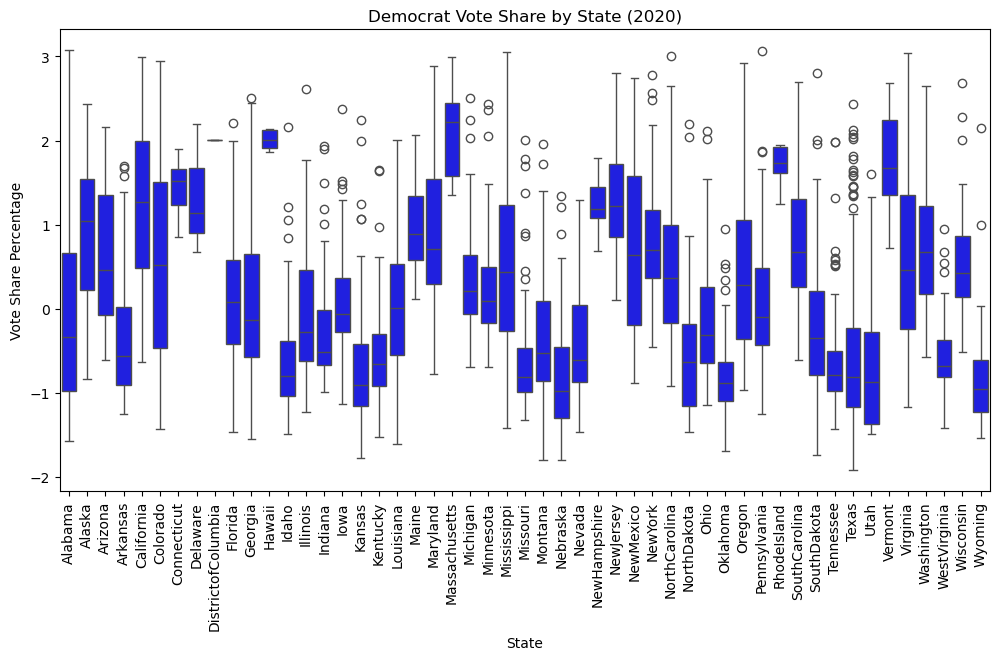

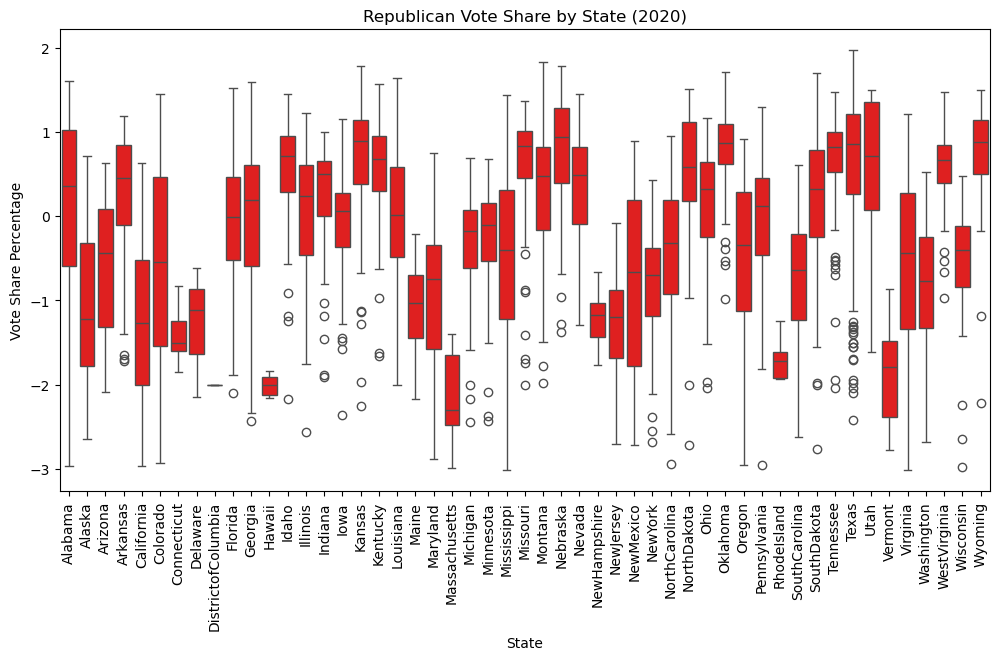

In [25]:
# Vote Share by State

plt.figure(figsize=(12, 6))
sns.boxplot(data=election_data, x='state', y='2020 Democrat vote %', color='blue')
plt.title('Democrat Vote Share by State (2020)')
plt.xticks(rotation=90)
plt.ylabel('Vote Share Percentage')
plt.xlabel('State')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=election_data, x='state', y='2020 Republican vote %', color='red')
plt.title('Republican Vote Share by State (2020)')
plt.xticks(rotation=90)
plt.ylabel('Vote Share Percentage')
plt.xlabel('State')
plt.show()

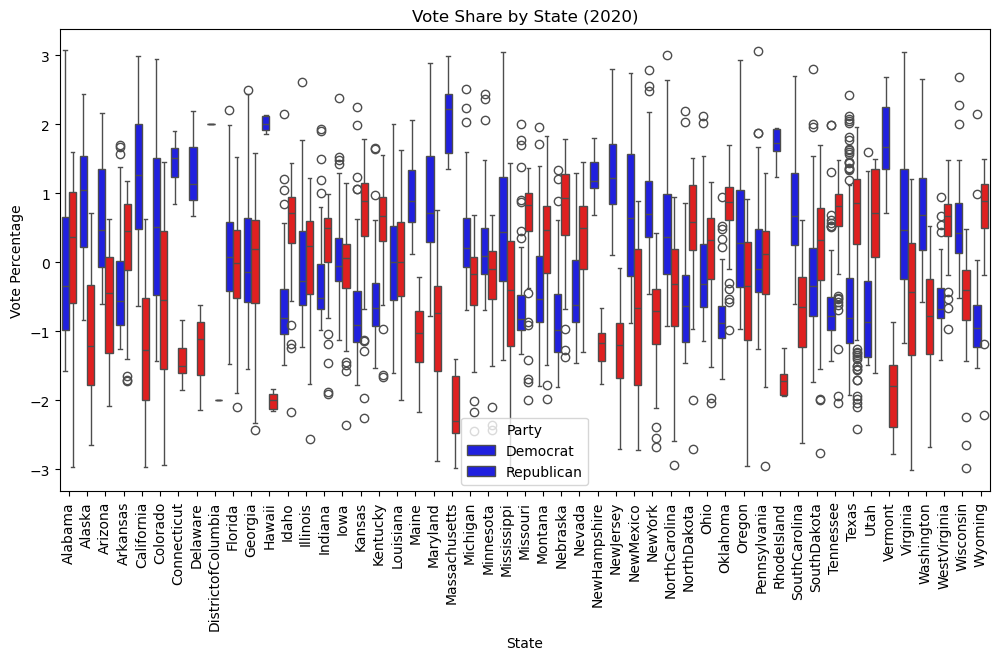

In [27]:
# Reshape data for combined plotting
reshaped_data = pd.melt(
    election_data, 
    id_vars=['state'], 
    value_vars=['2020 Democrat vote %', '2020 Republican vote %'], 
    var_name='Party', 
    value_name='Vote Percentage'
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=reshaped_data, x='state', y='Vote Percentage', hue='Party', palette={'2020 Democrat vote %': 'blue', '2020 Republican vote %': 'red'})
plt.title('Vote Share by State (2020)')
plt.xticks(rotation=90)
plt.ylabel('Vote Percentage')
plt.xlabel('State')
plt.legend(title='Party', labels=['Democrat', 'Republican'])
plt.show()


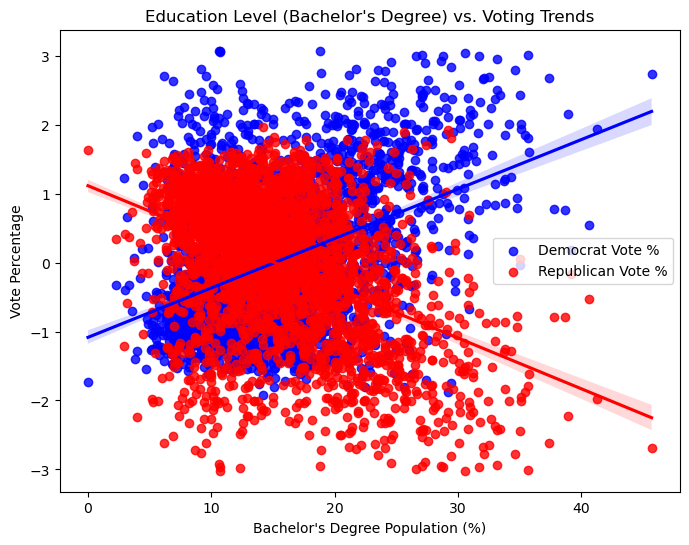

In [20]:
# Education Level vs. Voting Trends

# Convert education levels to numeric if necessary
education_columns = [
    'Population with less than 9th grade education',
    'Population with 9th to 12th grade education, no diploma', 
    'High School graduate and equivalent', 
    'Some College,No Degree', 'Associates Degree', 
    'Bachelors Degree', 'Graduate or professional degree'
]

for col in education_columns:
    election_data[col] = election_data[col].str.replace('%', '').astype(float)

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(data=election_data, x='Bachelors Degree', y='2020 Democrat vote %', color='blue', label='Democrat Vote %')
sns.regplot(data=election_data, x='Bachelors Degree', y='2020 Republican vote %', color='red', label='Republican Vote %')
plt.title('Education Level (Bachelor\'s Degree) vs. Voting Trends')
plt.xlabel('Bachelor\'s Degree Population (%)')
plt.ylabel('Vote Percentage')
plt.legend()
plt.show()


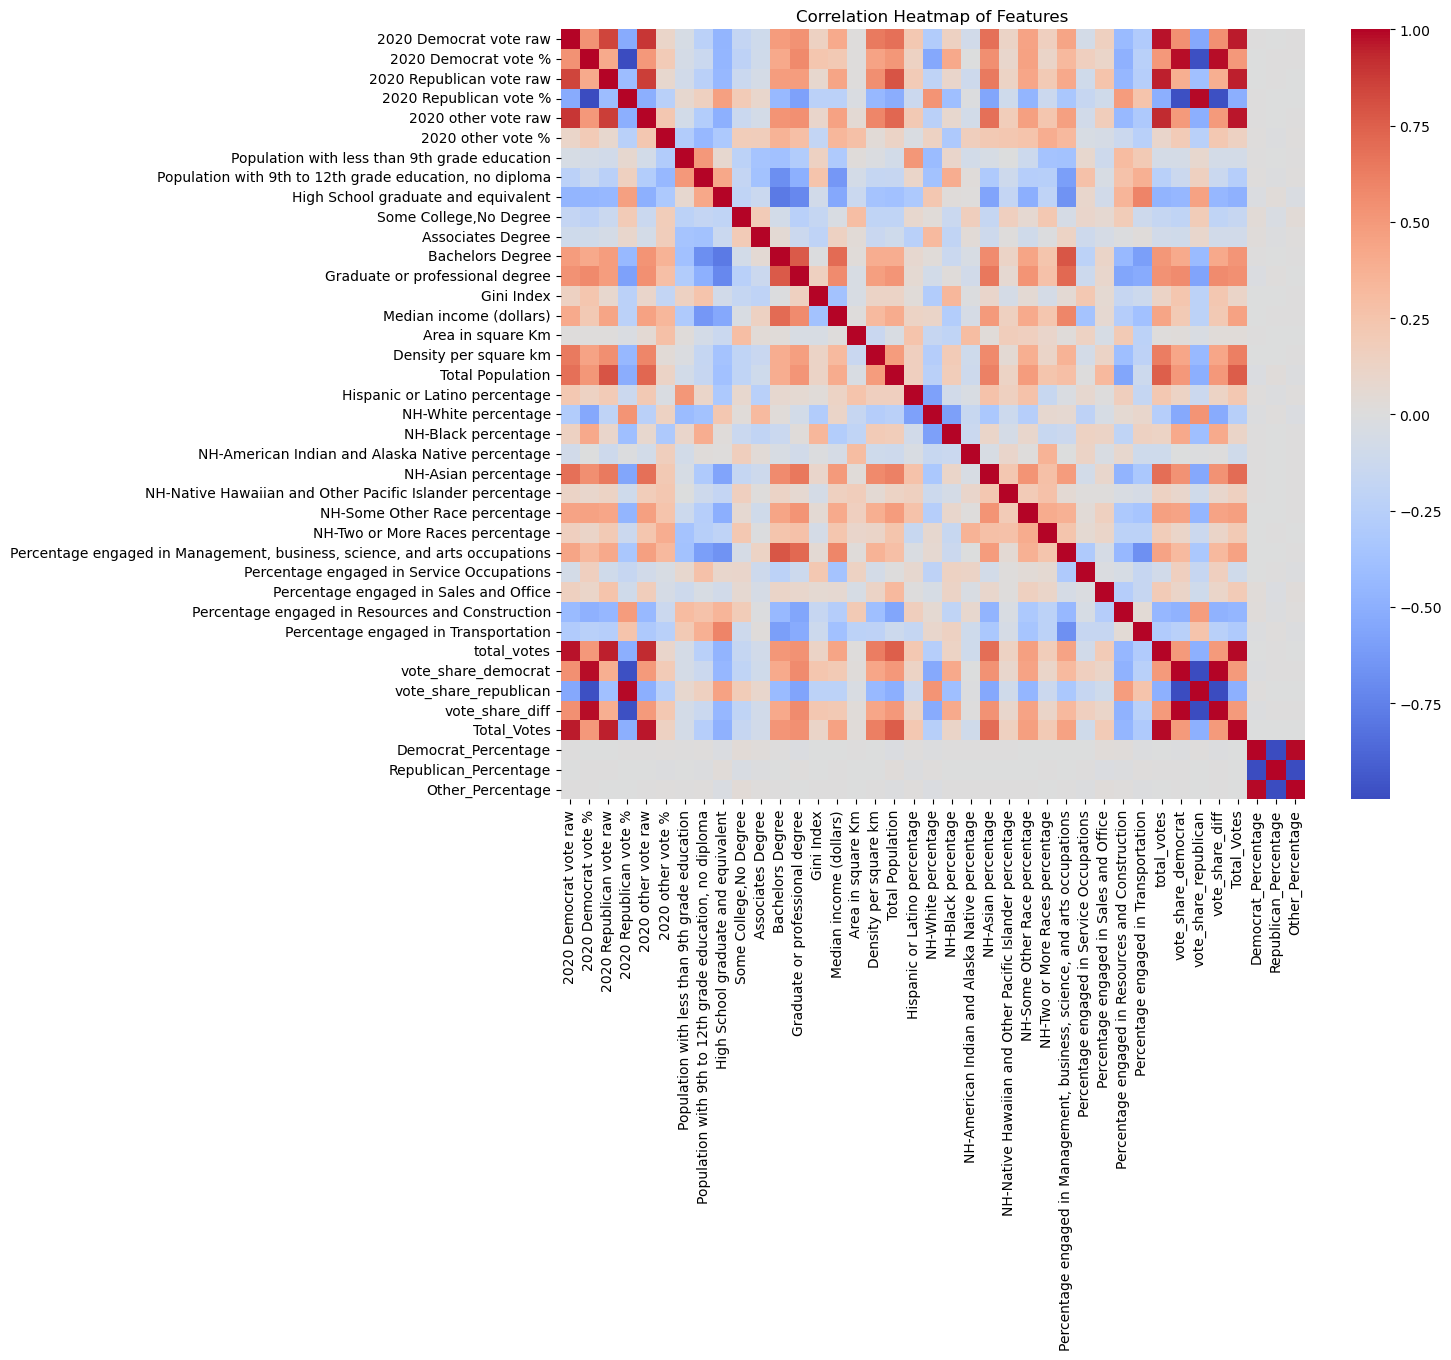

In [22]:
# Correlation Heatmap

# Select relevant numeric columns
numeric_cols = election_data.select_dtypes(include=['float64', 'int64']).columns

# Correlation matrix
corr_matrix = election_data[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()


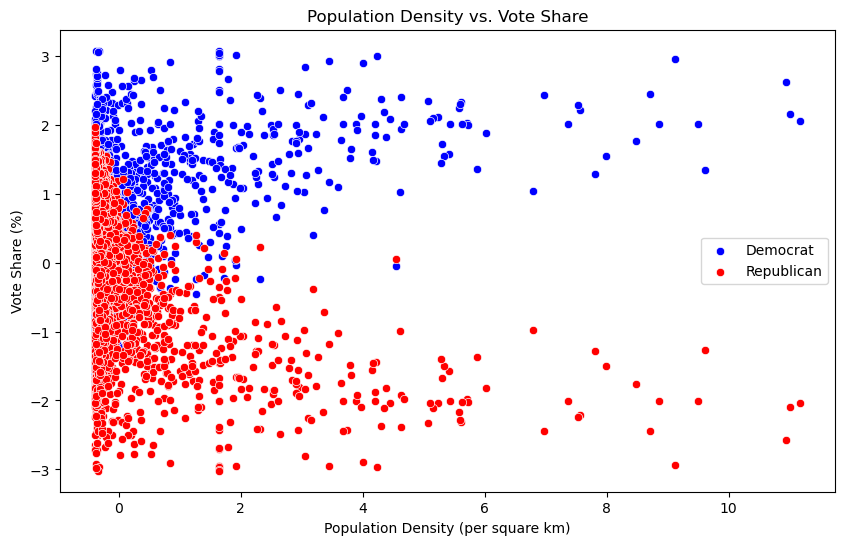

In [23]:
# Population Density and Vote Share

plt.figure(figsize=(10, 6))
sns.scatterplot(data=election_data, x='Density per square km', y='2020 Democrat vote %', color='blue', label='Democrat')
sns.scatterplot(data=election_data, x='Density per square km', y='2020 Republican vote %', color='red', label='Republican')
plt.title('Population Density vs. Vote Share')
plt.xlabel('Population Density (per square km)')
plt.ylabel('Vote Share (%)')
plt.legend()
plt.show()


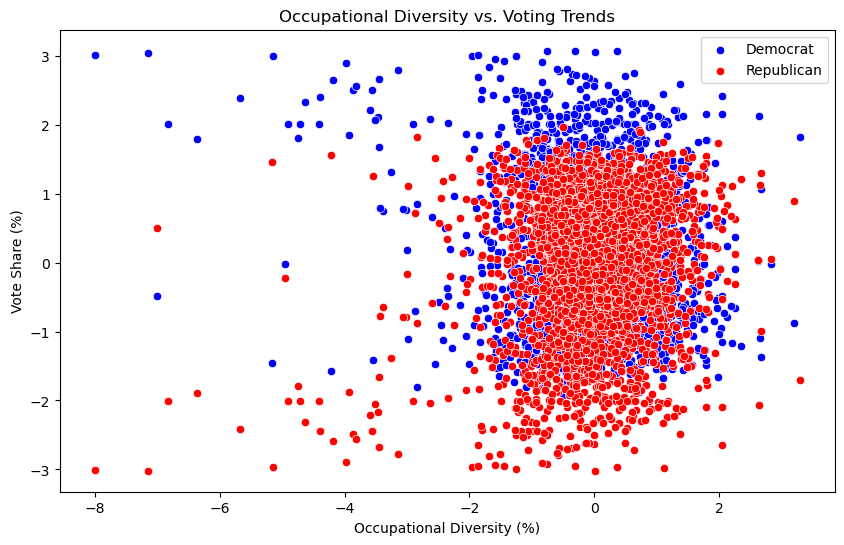

In [24]:
# Occupational Diversity and Voting Trends

occupation_columns = [
    'Percentage engaged in Management, business, science, and arts occupations',
    'Percentage engaged in Service Occupations',
    'Percentage engaged in Sales and Office',
    'Percentage engaged in Resources and Construction',
    'Percentage engaged in Transportation'
]

election_data['Occupational_Diversity'] = election_data[occupation_columns].sum(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=election_data, x='Occupational_Diversity', y='2020 Democrat vote %', color='blue', label='Democrat')
sns.scatterplot(data=election_data, x='Occupational_Diversity', y='2020 Republican vote %', color='red', label='Republican')
plt.title('Occupational Diversity vs. Voting Trends')
plt.xlabel('Occupational Diversity (%)')
plt.ylabel('Vote Share (%)')
plt.legend()
plt.show()


In [ ]:
# Correlation Heatmap for Features

plt.figure(figsize=(12, 8))
corr = election_data[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [ ]:
# Vote Share Difference (Democrat vs Republican)

plt.figure(figsize=(10, 6))
sns.boxplot(x=election_data['vote_share_diff'])
plt.title('Vote Share Difference (Democrat - Republican)')
plt.xlabel('Vote Share Difference')
plt.show()

In [ ]:
# Comparison of Education Levels and Vote Share

sns.pairplot(election_data[['vote_share_democrat', 'Population with less than 9th grade education',
                            'Population with 9th to 12th grade education, no diploma', 'High School graduate and equivalent']])
plt.show()

In [ ]:
# Group by the state columns and calculate the average vote share for each state

# Extract state columns
state_columns = [col for col in election_data.columns if col.startswith('state_')]

# Get the average vote share for each state
state_vote_share = election_data[state_columns].mean()

# Plotting the average vote share by state
plt.figure(figsize=(12, 6))
state_vote_share.sort_values().plot(kind='barh', color='blue')
plt.title('Average Democrat Vote Share by State')
plt.xlabel('Average Vote Share (%)')
plt.ylabel('State')
plt.show()

In [ ]:
# Income vs Vote Share (Democrat)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=election_data['Median income (dollars)'], y=election_data['vote_share_democrat'])
plt.title('Income vs Democrat Vote Share')
plt.xlabel('Median Income (dollars)')
plt.ylabel('Vote Share Democrat (%)')
plt.show()


In [ ]:
# Education vs Vote Share (Democrat)

plt.figure(figsize=(10, 6))
sns.lineplot(x='High School graduate and equivalent', y='vote_share_democrat', data=election_data)
plt.title('Education vs Democrat Vote Share')
plt.xlabel('High School Graduation Rate (%)')
plt.ylabel('Vote Share Democrat (%)')
plt.show()
